In [1]:
print("""
Riker Wachtler
29 October 2023
NLP Midterm Project
https://github.com/RikerW/midterm-nlp
""")


Riker Wachtler
29 October 2023
NLP Midterm Project
https://github.com/RikerW/midterm-nlp



In [2]:
# relevant imports/inits, loosely sorted by category

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import re

from pypdf import PdfReader

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

from textblob import TextBlob

import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\riker\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\riker\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
print("""
This is demonstrating various Natural Language Processing techniques we've learned so far in this class.

I got a small sample of some of my friend Conor's poetry, taken from some portfolio submission he did a bit ago. It's 8 pages total, though I had to skip the 7th since it's doesn't have any real text on it.

I read the text from a PDF directly via pypdf, including the titles for each poem & the name at the start, and then do a little immediate clean-up for some of the punctuation. It's mostly just putting periods at the end of stanzas without punctuation, since otherwise the tokenizer gets a little confused on what to break on - I didn't have to do this, but it seemed more conducive to interesting data.

After, the sentences are tokenized and some basic exploratory processing is done. Following that, the text is cleaned up - non-alpha words are purged, all words are cast to lowercase, etc.

Then, TF-IDF vectorization is done to get some of the most "important" sentences in the text - the top 3 are printed. It's a little biased towards longer sentences but it's not like the text isn't full of some of those.

Following the TF-IDF, less technical things are done - a WordCloud on both the original and cleaned up text, translating the original text to spanish, using displacy to identify important words in the original/cleaned up text, and then finally POS tagging & FreqDist counting of words in the original/cleaned up texts.
""")


This is demonstrating various Natural Language Processing techniques we've learned so far in this class.

I got a small sample of some of my friend Conor's poetry, taken from some portfolio submission he did a bit ago. It's 8 pages total, though I had to skip the 7th since it's doesn't have any real text on it.

I read the text from a PDF directly via pypdf, including the titles for each poem & the name at the start, and then do a little immediate clean-up for some of the punctuation. It's mostly just putting periods at the end of stanzas without punctuation, since otherwise the tokenizer gets a little confused on what to break on - I didn't have to do this, but it seemed more conducive to interesting data.

After, the sentences are tokenized and some basic exploratory processing is done. Following that, the text is cleaned up - non-alpha words are purged, all words are cast to lowercase, etc.

Then, TF-IDF vectorization is done to get some of the most "important" sentences in the tex

In [4]:
# Read the poetry from a PDF - ignore the 7th page, it has an image that inspired one of the poems, so skip it

reader = PdfReader("data/obrien_portfolio.pdf")
text = ""
for page in enumerate(reader.pages):
    if (page[0] == 6):
        continue; # that page has an image & url on it, skip it
    text += page[1].extract_text()[:-4] + ".\n \n"

text = text[:-4]

# Process the data a bit - cleaning up quotes because I felt like it, turning em-dashes into periods
# and then putting periods after stanzas without punctuation.
# due to the nature of this poetry, otherwise certain stanzas
# have no punctuation whatsoever so they all get lumped into one "sentence"
# lastly, each line gets its funky whitespace stripped, and any empty lines get skipped. len==1 catches haiku numbers

text = re.sub(r"[“”]", r'"', text)
text = re.sub(r"[—]", r".", text)
text = re.sub(r"([^!?.,:;]) \n \n", r"\1.\n", text)
text_arr = [line.strip() for line in text.split("\n") if len(line.strip()) > 1]
text = "\n".join(text_arr)

print(text)

Poetry Portfolio
Conor O’Brien
Haiku
wet feet, hot-sand caked
tracing yesterday’s footprints
‘til winter takes hold.
as the sun sinks low
we chase parasite squirrels
while hummingbirds drink.
dusk air, dance freely!
navigate new jersey streets,
be my melody.
a captive pine stands
shaking, tall amid its kin,
now ours for Christmas.
in yellow canoe,
paddles stuck in mud and grime,
we pause for a breath.
heaven’s tsunami
crashes over high mountains.
fitting for a walk.
Blank Verse
these my thoughts.
anonymized by arbored trails near roads
unkempt i lumber far away from these
my thoughts of you and what we could have been;
unstill, you pull me back, and still i trudge
onwards past the empty lots, reflecting:
if you could name a place where i belong
then maybe i could reach out to the past
and give myself some tips; that maybe then
i’d find a straighter path to where i am
supposed to go from here.
if you could lead us now and teach me how
to dance upon the path of those regrets,
then maybe 

In [5]:
# Tokenize the sentences :)
# The info is the closest I have to EDA, since there's not too many preliminary statistics for text
sentences = sent_tokenize(text)
print(f"Total number of sentences: {len(sentences)}")
print(f"Longest sentence: {max(sentences, key=len)}")
print(f"Shortest sentence: {min(sentences, key=len)}")
print()
print("All sentences:")
for s in sentences: print(s)

Total number of sentences: 70
Longest sentence: anonymized by arbored trails near roads
unkempt i lumber far away from these
my thoughts of you and what we could have been;
unstill, you pull me back, and still i trudge
onwards past the empty lots, reflecting:
if you could name a place where i belong
then maybe i could reach out to the past
and give myself some tips; that maybe then
i’d find a straighter path to where i am
supposed to go from here.
Shortest sentence: i’ll

All sentences:
Poetry Portfolio
Conor O’Brien
Haiku
wet feet, hot-sand caked
tracing yesterday’s footprints
‘til winter takes hold.
as the sun sinks low
we chase parasite squirrels
while hummingbirds drink.
dusk air, dance freely!
navigate new jersey streets,
be my melody.
a captive pine stands
shaking, tall amid its kin,
now ours for Christmas.
in yellow canoe,
paddles stuck in mud and grime,
we pause for a breath.
heaven’s tsunami
crashes over high mountains.
fitting for a walk.
Blank Verse
these my thoughts.
anonym

In [6]:
# Define preprocessing function, which uses re.sub to clean non-alphanumeric characters out of the text,
# then cast to lowercase & skip any other non-alpha words that got missed somehow

def preprocess_text(text):
    words = word_tokenize(text)
    cleaned_words = word_tokenize(re.sub(r'[^a-zA-Z]', ' ', text))
    cleaned_words = [word.lower() for word in cleaned_words if word.isalnum() and word not in stop_words]
    return ' '.join(cleaned_words)

# Create our cleaned up list of sentences & text, for use with TF-IDF vectorization and then later fun visuals
prepped_sentences = list(map(preprocess_text, sentences))
cleaned_text = '\n'.join(prepped_sentences)
print(cleaned_text)

poetry portfolio conor o brien haiku wet feet hot sand caked tracing yesterday footprints til winter takes hold
sun sinks low chase parasite squirrels hummingbirds drink
dusk air dance freely
navigate new jersey streets melody
captive pine stands shaking tall amid kin christmas
yellow canoe paddles stuck mud grime pause breath
heaven tsunami crashes high mountains
fitting walk
blank verse thoughts
anonymized arbored trails near roads unkempt lumber far away thoughts could unstill pull back still trudge onwards past empty lots reflecting could name place belong maybe could reach past give tips maybe find straighter path supposed go
could lead us teach dance upon path regrets maybe could come life live little freer friend day taxing exercise navigate maze spike like glass spiderwebs ever one mistake fatal mind
lift eyes taste air awhile avoid asphalt asphyxiation alongside sidewalk streetlamps burning behind forest cover like eyes fire procession tin saints ever fixed place guide lost ni

In [7]:
# TF-IDF vectorize this stuff - specifically the tokenized sentences, but not cleaned up ones
# We're going to use this to find the most common words in conor's poetry :)
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(sentences)
tfidf_scores = tfidf_matrix.sum(axis=1)
print(tfidf_scores)

[[4.12138604]
 [3.39360051]
 [1.99536585]
 [2.62484596]
 [3.44703519]
 [3.39095175]
 [2.44721742]
 [1.71053604]
 [2.21301886]
 [7.17849045]
 [7.03251175]
 [6.8683727 ]
 [5.74123405]
 [5.79385864]
 [2.37086184]
 [4.2049492 ]
 [5.04024229]
 [1.98379383]
 [2.21832478]
 [4.40523922]
 [3.74388884]
 [4.38223042]
 [1.98379383]
 [2.6264567 ]
 [3.88633045]
 [2.14171083]
 [4.2660167 ]
 [2.18772957]
 [4.10340509]
 [2.79770193]
 [4.18516571]
 [2.95257446]
 [4.37880074]
 [2.79090968]
 [4.05926931]
 [3.36092022]
 [4.30209011]
 [2.95761001]
 [1.73044403]
 [3.55159953]
 [3.3239961 ]
 [3.36385363]
 [3.08804878]
 [4.55835356]
 [3.64989445]
 [1.70988049]
 [2.15561497]
 [4.46691743]
 [3.92231032]
 [4.29156801]
 [4.54024232]
 [4.03686076]
 [3.81096794]
 [2.56417358]
 [1.94784766]
 [2.19174694]
 [2.53357566]
 [2.09954889]
 [2.22116776]
 [5.06826641]
 [5.35969289]
 [2.62718096]
 [2.60587583]
 [4.67051387]
 [2.18290234]
 [3.86027924]
 [2.80157834]
 [2.19603407]
 [1.98864222]
 [1.        ]]


In [8]:
top_sentence_indices = np.argsort(tfidf_scores, axis=0)[-3:]
for index in top_sentence_indices:
    val = sentences[index[0,0]]
    print(val, "\n")

i lift my eyes to taste the air awhile
and avoid asphalt asphyxiation
alongside sidewalk streetlamps burning
behind the forest’s cover, like eyes on fire,
a procession of tin-can saints, ever fixed
in place to guide the lost at night to home;
no sign of you there in that train, you struck
a different path out through the wilder weeds. 

if you could lead us now and teach me how
to dance upon the path of those regrets,
then maybe i could come to life and live
a little freer than before; my friend,
each day’s a taxing exercise in how
to navigate the maze of spike-like glass
which spiderwebs all that i’ll ever do,
where one mistake is fatal in my mind. 

anonymized by arbored trails near roads
unkempt i lumber far away from these
my thoughts of you and what we could have been;
unstill, you pull me back, and still i trudge
onwards past the empty lots, reflecting:
if you could name a place where i belong
then maybe i could reach out to the past
and give myself some tips; that maybe then
i’d

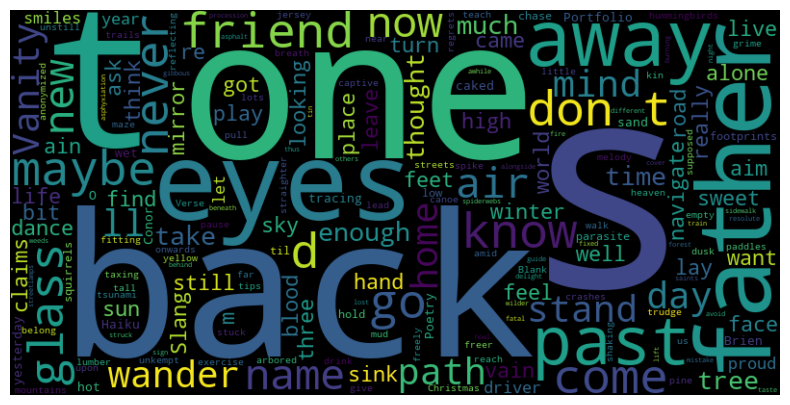

In [9]:
# Word cloud for original text
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

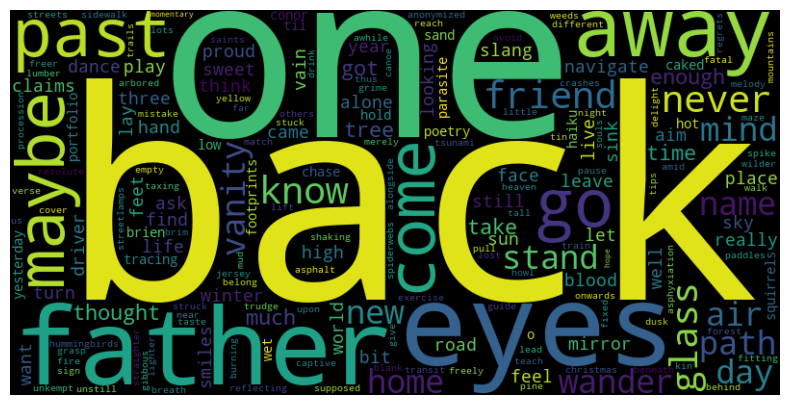

In [10]:
# Word cloud for cleaned text, for fun
wordcloud = WordCloud(width=800, height=400, background_color="black").generate(cleaned_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [11]:
# Translate the text to Spanish
blob = TextBlob(text)
translated_blob = blob.translate('en', 'es')
print(translated_blob)

Cartera de poesía
Conor O'Brien
Haiku
Pies mojados, capado de arena caliente
rastrear las huellas de ayer
‘Hasta el invierno se apodera.
A medida que el sol se hunde
perseguimos ardillas de parásito
mientras los colibríes beben.
¡Aire anochecer, baila libremente!
navegar por las calles de Nueva Jersey,
ser mi melodía.
Un pino cautivo se encuentra
temblando, alto en medio de sus parientes,
Ahora el nuestro para Navidad.
en canoa amarilla,
paletas atrapadas en barro y mugre,
Hacemos una pausa por respirar.
Tsunami del cielo
se bloquea sobre las altas montañas.
apropiado para caminar.
Verso en blanco
Estos mis pensamientos.
anonimizado por senderos arboriosos cerca de las carreteras
desagradable, me quedo lejos de estos
Mis pensamientos sobre ti y lo que podríamos haber sido;
Desconectado, me retiras, y aún así me puse caminando
En adelante, más allá de los lotes vacíos, reflejando:
Si pudieras nombrar un lugar donde pertenezco
Entonces tal vez podría comunicarme con el pasado
Y dame algu

In [12]:
colors = {'PERSON': 'linear-gradient(90deg, #aa9cfc, #fc9ce7)', 
          'DATE': 'linear-gradient(90deg, #34ebb4, #9c34eb)',
          'ORG': 'linear-gradient(90deg, #eb3d34, #ebe834)',
          'GPE': 'linear-gradient(90deg, #eb34d9, #bd0636)',
          'TIME': 'linear-gradient(90deg, #9bbd06, #06bd89)',
          'NORP': 'linear-gradient(90deg, #067dbd, #1206bd)',
          'CARDINAL': 'linear-gradient(90deg, #06b4bd, #de0942)',
          
         }

options = {'ents': ['PERSON', 'DATE', 'ORG', 'GPE', 'TIME', 'NORP', 'CARDINAL'], 'colors':colors}

In [13]:
# Display the original text, and label 
doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True, options = options)

In [14]:
doc = nlp(cleaned_text)
displacy.render(doc, style='ent', jupyter=True, options = options)

In [15]:
words = word_tokenize(text)
print(f"Total words in original text: {len(words)}")
print("Parts of speech for each word (dupes removed):")
for i in sorted(list(set(nltk.pos_tag(words)))): print(i)

Total words in original text: 1405
Parts of speech for each word (dupes removed):
('!', '.')
('&', 'CC')
("''", "''")
('(', '(')
(')', ')')
(',', ',')
('.', '.')
('..', 'NNP')
(':', ':')
(';', ':')
('?', '.')
('Babel', 'NNP')
('Blank', 'NNP')
('Blues/Rap', 'NNP')
('Brien', 'NNP')
('Christmas', 'NNP')
('Conor', 'NNP')
('Cypress', 'NNP')
('Deaths', 'NNP')
('Ekphrastic', 'JJ')
('Epistolary', 'NNP')
('GD', 'NNP')
('Haiku', 'NNP')
('O', 'NNP')
('Paris', 'NNP')
('Poetry', 'NNP')
('Portfolio', 'NNP')
('Slang', 'NNP')
('Surrealism', 'NN')
('TVs', 'NNP')
('Vanity', 'NNP')
('Verse', 'NNP')
('``', '``')
('a', 'DT')
('about', 'IN')
('abyss', 'NN')
('aces', 'NNS')
('act', 'NN')
('add', 'NN')
('again', 'RB')
('aim', 'NN')
('aims', 'VBZ')
('ain', 'JJ')
('ain', 'NN')
('air', 'NN')
('alarmed', 'VBD')
('alfred', 'JJ')
('all', 'DT')
('all', 'PDT')
('all-in', 'NN')
('alone', 'RB')
('alongside', 'IN')
('also', 'RB')
('although', 'IN')
('always', 'RB')
('am', 'VBP')
('amassed', 'VBD')
('amid', 'IN')
('and',

Most common words (with #):
(',', 89)
('.', 62)
('the', 49)
('’', 45)
('i', 37)
('to', 35)
('and', 25)
('you', 23)
('a', 22)
('s', 19)


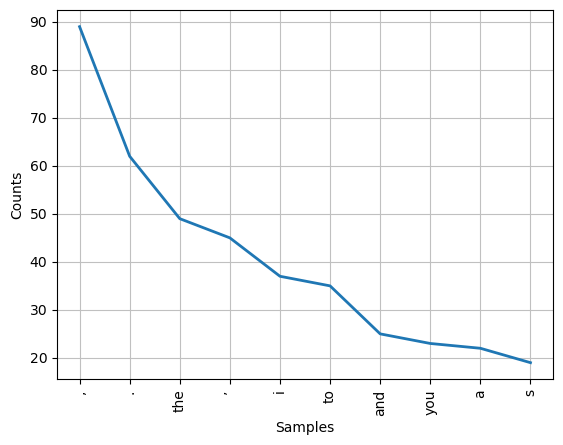

In [16]:
fdist = FreqDist(words)
print("Most common words (with #):")
for i in fdist.most_common(10): print(i)
fdist.plot(10)
plt.show()

In [17]:
words = word_tokenize(cleaned_text)
print(f"Total words in cleaned-up text: {len(words)}")
print("Parts of speech for each word (dupes removed):")
for i in sorted(list(set(nltk.pos_tag(words)))): print(i)

Total words in cleaned-up text: 642
Parts of speech for each word (dupes removed):
('abyss', 'NN')
('aces', 'NNS')
('act', 'JJ')
('add', 'VBP')
('aim', 'NN')
('aims', 'JJ')
('air', 'NN')
('alarmed', 'VBD')
('alfred', 'VBD')
('alone', 'RB')
('alongside', 'IN')
('also', 'RB')
('although', 'IN')
('always', 'RB')
('amassed', 'VBN')
('amid', 'IN')
('anonymized', 'VBN')
('apartment', 'NN')
('arbored', 'VBD')
('ash', 'NN')
('ashtray', 'NN')
('ask', 'VB')
('asks', 'NNS')
('asphalt', 'NN')
('asphyxiation', 'NN')
('ate', 'NN')
('attack', 'NN')
('averts', 'NNS')
('avoid', 'JJ')
('awake', 'JJ')
('away', 'RB')
('awhile', 'IN')
('babel', 'NN')
('back', 'RB')
('back', 'RP')
('backburner', 'NN')
('behind', 'IN')
('behold', 'VBD')
('beholding', 'VBG')
('belong', 'IN')
('beneath', 'RB')
('betray', 'VBP')
('better', 'RB')
('beyond', 'IN')
('binge', 'NN')
('birds', 'NNS')
('bisect', 'NN')
('bit', 'NN')
('bit', 'RB')
('blame', 'NN')
('blamed', 'VBN')
('blank', 'JJ')
('blare', 'VBP')
('bleeding', 'VBG')
('b

Most common words (with #):
('could', 9)
('back', 7)
('one', 7)
('eyes', 6)
('father', 5)
('away', 4)
('past', 4)
('maybe', 4)
('go', 4)
('friend', 4)


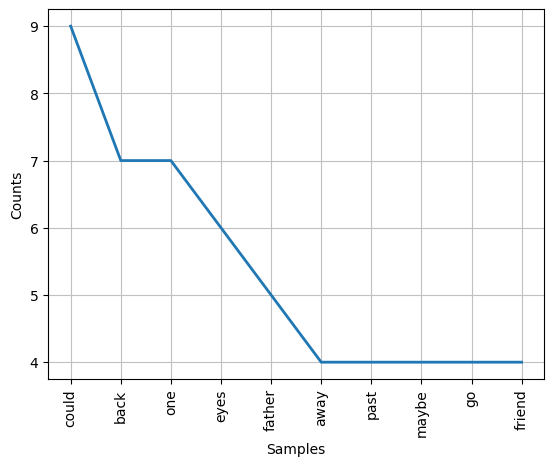

In [18]:
fdist = FreqDist(words)
print("Most common words (with #):")
for i in fdist.most_common(10): print(i)
fdist.plot(10)
plt.show()

In [19]:
print("""

Overall, this was pretty interesting data to look at. I was curious to see which words were most common here and what that says about the poetry, but also curious from a technical standpoint what happens with really long 'sentences' like in Conor's poetry.

It's especially interesting the things that spacy highlights - like "grey forecast" as a person, for some reason, which is obviously not right. I guess it doens't really like very figurative/flowery language.

The WordClouds were also pretty fun to look at - I didn't realize "back" was such a common word in general let alone in this poetry.

One downside I did notice - TF-IDF seems very awkward for very varying sentence lengths. It really liked the longest sentences, presumably since they share a lot of similarities etc. with the other ones, but that's something to consider when using TF-IDF with future datasets.
""")



Overall, this was pretty interesting data to look at. I was curious to see which words were most common here and what that says about the poetry, but also curious from a technical standpoint what happens with really long 'sentences' like in Conor's poetry.

It's especially interesting the things that spacy highlights - like "grey forecast" as a person, for some reason, which is obviously not right. I guess it doens't really like very figurative/flowery language.

The WordClouds were also pretty fun to look at - I didn't realize "back" was such a common word in general let alone in this poetry.

One downside I did notice - TF-IDF seems very awkward for very varying sentence lengths. It really liked the longest sentences, presumably since they share a lot of similarities etc. with the other ones, but that's something to consider when using TF-IDF with future datasets.

